In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, plot
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline
import math as m

pd.set_option('display.max_columns', None)
plt.style.use('bmh')

In [16]:
zipcodes = pd.read_csv('DataSets/SF_Population/ziplatlong.csv', sep=';')
police_incidents_new = pd.read_csv('DataSets/Stadium Impact/Police_Department_Incident_Reports__2018_to_Present.csv')

## Initial Data Exploration - Police Incidents from 2018 - 2020

In [5]:
police_incidents_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335262 entries, 0 to 335261
Data columns (total 36 columns):
Incident Datetime                                       335262 non-null object
Incident Date                                           335262 non-null object
Incident Time                                           335262 non-null object
Incident Year                                           335262 non-null int64
Incident Day of Week                                    335262 non-null object
Report Datetime                                         335262 non-null object
Row ID                                                  335262 non-null int64
Incident ID                                             335262 non-null int64
Incident Number                                         335262 non-null int64
CAD Number                                              257478 non-null float64
Report Type Code                                        335262 non-null object
Report Type Description

In [6]:
police_incidents_new.isnull().sum()

Incident Datetime                                            0
Incident Date                                                0
Incident Time                                                0
Incident Year                                                0
Incident Day of Week                                         0
Report Datetime                                              0
Row ID                                                       0
Incident ID                                                  0
Incident Number                                              0
CAD Number                                               77784
Report Type Code                                             0
Report Type Description                                      0
Filed Online                                            262841
Incident Code                                                0
Incident Category                                           92
Incident Subcategory                                   

**Looks like there are some null values in Neighborhood, Latitude, and Longitude. Which are all necessary to narrow down reporting to Dogpatch/Mission Bay. Let's see if there's any useful info in the null containing rows**

In [7]:
police_incidents_new[police_incidents_new['Latitude'].isna()]
#Upon looking at the NaN values, we don't have any information on where this happened in SF. 
#We can use this for overall view of police incidents, but best not to use them for neighborhood based analysis.

,Incident Datetime,Incident Date,Incident Time,Incident Year,Incident Day of Week,Report Datetime,Row ID,Incident ID,Incident Number,CAD Number,Report Type Code,Report Type Description,Filed Online,Incident Code,Incident Category,Incident Subcategory,Incident Description,Resolution,Intersection,CNN,Police District,Analysis Neighborhood,Supervisor District,Latitude,Longitude,point,SF Find Neighborhoods,Current Police Districts,Current Supervisor Districts,Analysis Neighborhoods,HSOC Zones as of 2018-06-05,OWED Public Spaces,Central Market/Tenderloin Boundary Polygon - Updated,Parks Alliance CPSI (27+TL sites),ESNCAG - Boundary File,"Areas of Vulnerability, 2016"
19,2019/06/22 08:52:00 PM,2019/06/22,20:52,2019,Saturday,2019/06/22 08:52:00 PM,81452171012,814521,161010198,NaN,VS,Vehicle Supplement,NaN,71012,Other Offenses,Other Offenses,"License Plate, Recovered",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,2019/04/30 08:00:00 AM,2019/04/30,08:00,2019,Tuesday,2019/04/30 08:01:00 AM,79597307041,795973,190251218,NaN,VS,Vehicle Supplement,NaN,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44,2018/12/12 10:54:00 AM,2018/12/12,10:54,2018,Wednesday,2018/12/12 11:00:00 AM,74736407041,747364,180919147,NaN,VS,Vehicle Supplement,NaN,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,2019/09/25 08:00:00 PM,2019/09/25,20:00,2019,Wednesday,2019/10/02 09:40:00 AM,85429306313,854293,190722269,NaN,IS,Coplogic Supplement,True,6313,Larceny Theft,Larceny Theft - Bicycle,"Theft, Bicycle, $200-$950",Open or Active,NaN,NaN,Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,2020/02/03 01:00:00 PM,2020/02/03,13:00,2020,Monday,2020/02/03 01:01:00 PM,89872207043,898722,190827524,NaN,VS,Vehicle Supplement,NaN,7043,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Motorcycle",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335157,2019/01/16 03:00:00 PM,2019/01/16,15:00,2019,Wednesday,2019/01/16 09:01:00 PM,76044106244,760441,196010759,NaN,II,Coplogic Initial,True,6244,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335196,2019/04/08 04:53:00 PM,2019/04/08,16:53,2019,Monday,2019/04/08 04:53:00 PM,78831907041,788319,190226277,190982791.0,VS,Vehicle Supplement,NaN,7041,Recovered Vehicle,Recovered Vehicle,"Vehicle, Recovered, Auto",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335199,2018/10/24 11:30:00 PM,2018/10/24,23:30,2018,Wednesday,2018/10/31 05:20:00 PM,73817506374,738175,1831875,NaN,IS,Coplogic Supplement,True,6374,Larceny Theft,Larceny Theft - Other,"Theft, Other Property, >$950",Open or Active,NaN,NaN,Out of SF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335200,2019/08/04 10:05:00 AM,2019/08/04,10:05,2019,Sunday,2019/08/04 04:15:00 PM,83092306372,830923,196158371,NaN,II,Coplogic Initial,True,6372,Larceny Theft,Larceny Theft - Other,"Theft, Other Property, $50-$200",Open or Active,NaN,NaN,Mission,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

**Updating Date to Datetime format, adding Month, Month-Year & Year for Analysis purposes**

In [17]:
import calendar
police_incidents_new['Incident Date'] = pd.to_datetime(police_incidents_new['Incident Date'])
police_incidents_new['Month'] = police_incidents_new['Incident Date'].transform(lambda x: x.month)
police_incidents_new['Month-Year'] = police_incidents_new['Incident Date'].transform(lambda x: f'{calendar.month_abbr[x.month]} {x.year}')
police_incidents_new['Incident Date'].min(), police_incidents_new['Incident Date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2020-04-07 00:00:00'))

In [18]:
#Converting NaNs to 0 for the zipcode calculation function
police_incidents_new = police_incidents_new.fillna(0)

**Currently the data only includes neighborhoods, latitude, and longitude. We will use latitude/longitude to calculate the nearest zipcode, so we can compare the same zipcodes for both the Fire Department Call Volumes & Police Incidents.**

In [19]:
from geopy.distance import geodesic
test=[37.7196874952717, -122.476327815126]

def closest_pt(row):
    distances=[]
    zips=zipcodes[['Latitude','Longitude']]
    for elem in range(len(zipcodes.index)):
        try:
            dist = geodesic((row[0],row[1]), (zips.iloc[elem,0],zips.iloc[elem,1]))
            distances.append(dist)
        except ValueError:   
            continue
    return zipcodes.iloc[np.argmin(distances),0]

closest_pt(test)

94132

In [20]:
zips = police_incidents_new.groupby(['Latitude','Longitude'])['Incident Date'].count().reset_index()
zips['Lat_Long'] = zips[['Latitude', 'Longitude']].values.tolist()
zips['Zipcode'] = zips['Lat_Long'].apply(closest_pt)
zips['str1']=zips['Latitude'].transform(lambda x: str(x))
zips['str2']=zips['Longitude'].transform(lambda x: str(x))
zips['indx']=zips['str1']+zips['str2']
# zips.to_csv('2018presentzips')
# zips = pd.read_csv('2018presentzips')

police_incidents_new['str1']=police_incidents_new['Latitude'].transform(lambda x: str(x))
police_incidents_new['str2']=police_incidents_new['Longitude'].transform(lambda x: str(x))
police_incidents_new['indx']=police_incidents_new['str1']+police_incidents_new['str2']
polpresent = pd.merge(police_incidents_new, zips, on='indx')
polpresent = polpresent.drop(columns=['str1_x','str2_x','indx','Latitude_y',
                                     'Longitude_y','Incident Date_y',
                                     'str1_y','str2_y'])
polpresent['Incident Date_x']=pd.to_datetime(polpresent['Incident Date_x'])
polpresent = polpresent.rename(columns={'Incident Date_x': 'Incident Date'})

## Normalizing the Data for change in Population

In [21]:
year= np.arange(2000,2020+1)
pop=[777340,777613,755862,757638,750133,748846,751431,758348,767067,774347,805463,812826,825865,837442,852469,
     864816,883305,884363,883305,881549,884363]
d={'year': year, 'pop': pop}
sf_pop_df = pd.DataFrame(d).sort_values('year')

polpresent['Norm'] = 1
for idx in range(0,len(sf_pop_df)):
    polpresent.loc[polpresent['Incident Year']==sf_pop_df.iloc[idx,0],'Norm'] = 1/(sf_pop_df.iloc[idx,1])

## Reducing the dataset to look specifically at Mission Bay & Dogpatch Neighborhoods only

In [36]:
cats_of_interest = ['Non-Criminal','Stolen Property','Miscellaneous Investigation',
                    'Other Miscellaneous','Assault', 'Larceny Theft', 'Malicious Mischief', 
                    'Disorderly Conduct','Traffic Collision', 'Liquor Laws', 
                    'Fire Report', 'Suspicious', 'Drug Offense',
                    'Suspicious Occ','Traffic Violation Arrest', 'Other Offenses', 'Other',
                   'Drug Violation', 'Civil Sidewalks', 'Fire Report']
zipcodes_of_interest = ['94107','94103', '94158', '94105']
neighbors_of_interest = ['Mission', 'Financial District/South Beach','South of Market','Mission Bay',
                          'Potrero Hill']

In [37]:
polpresentzip = polpresent[['Incident Category','Incident Description','Incident Date','Month','Month-Year',
                              'Incident Year','Incident Time','Zipcode','Police District','Longitude_x','Latitude_x',
                              'Analysis Neighborhoods', 'Incident Day of Week', 'Norm']][(polpresent['Zipcode'].isin(zipcodes_of_interest)) &
                                       (polpresent['Incident Category'].isin(cats_of_interest)) ]

In [38]:
polpresentneighbor = polpresent[['Incident Category','Incident Description','Incident Date','Month','Month-Year',
                              'Incident Year','Incident Time','Zipcode','Police District','Longitude_x','Latitude_x',
                              'Analysis Neighborhoods', 'Incident Day of Week', 'Norm']][(polpresent['Analysis Neighborhood'].isin(neighbors_of_interest)) &
                                       (polpresent['Incident Category'].isin(cats_of_interest)) ]

In [39]:
polpresentneighbor.groupby('Month').count()['Incident Date']

Month
1     7893
2     7332
3     7072
4     5539
5     5489
6     5321
7     5893
8     5870
9     5537
10    5506
11    5297
12    4896
Name: Incident Date, dtype: int64

In [40]:
polpresentzip.groupby(['Incident Year','Month']).count()['Incident Date']
#Going with the same zipcodes as the Fire Department Group for consistency

Incident Year  Month
2018           1        1609
               2        1454
               3        1540
               4        1554
               5        1415
               6        1438
               7        1587
               8        1493
               9        1596
               10       1494
               11       1388
               12       1278
2019           1        1285
               2        1188
               3        1299
               4        1294
               5        1370
               6        1302
               7        1428
               8        1510
               9        1329
               10       1396
               11       1388
               12       1261
2020           1        1217
               2        1154
               3         985
               4         102
Name: Incident Date, dtype: int64

In [30]:
polpresentzip.head()

,Incident Category,Incident Description,Incident Date,Month,Month-Year,Incident Year,Incident Time,Zipcode,Police District,Longitude_x,Latitude_x,Analysis Neighborhoods,Incident Day of Week,Norm
20,Non-Criminal,Mental Health Detention,2019-06-22,6,Jun 2019,2019,07:45,94103,Southern,-122.408161,37.780535,34.0,Saturday,0.000001
23,Assault,"Battery, former Spouse or Dating Relationship",2020-02-03,2,Feb 2020,2020,19:08,94103,Southern,-122.408161,37.780535,34.0,Monday,0.000001
25,Malicious Mischief,"Malicious Mischief, Vandalism to Property",2019-03-06,3,Mar 2019,2019,11:01,94103,Southern,-122.408161,37.780535,34.0,Wednesday,0.000001
26,Assault,"Assault, Aggravated, W/ Other Weapon",2020-02-05,2,Feb 2020,2020,04:24,94103,Southern,-122.408161,37.780535,34.0,Wednesday,0.000001
27,Other Miscellaneous,Probation Violation,2020-02-05,2,Feb 2020,2020,04:24,94103,Southern,-122.408161,37.780535,34.0,Wednesday,0.000001


# Exploratory Data Analysis 

In [129]:
dataset = polpresentzip

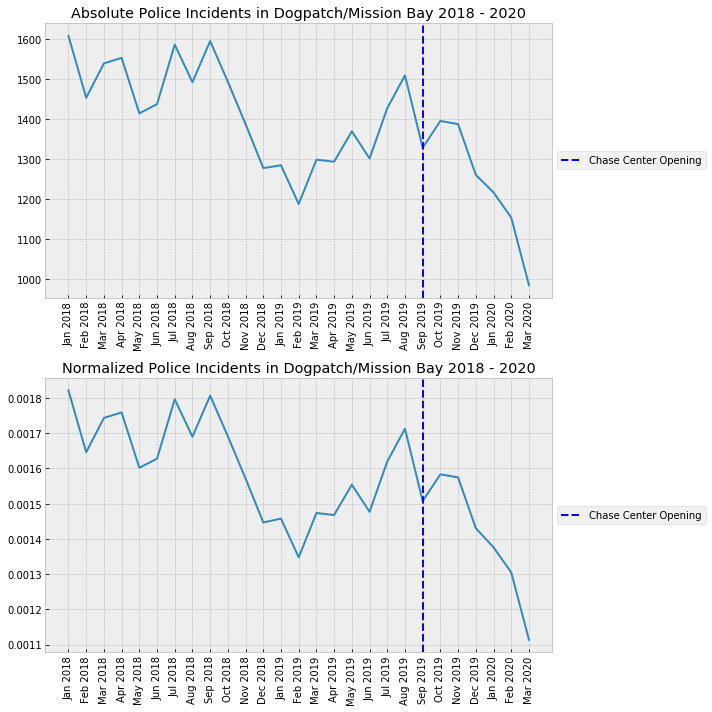

In [130]:
date_range = pd.date_range(start='2018-01-01', end='2020-03-31')
poljul19 = dataset[dataset['Incident Date'].isin(date_range)].sort_values(['Incident Date'])
calls = poljul19['Incident Category'].unique()
labels = poljul19.groupby(['Incident Year','Month']).count()['Incident Date']
min_year = poljul19['Incident Year'].min()
max_year = poljul19['Incident Year'].max()
plot_title = 'Police Incidents in Dogpatch/Mission Bay'
num_months_xticks = 1

fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(poljul19['Month-Year'].unique(),poljul19.groupby(['Incident Year','Month']).count()['Incident Date'])
ax[0].axvline('Sep 2019', ls='--',color='blue', label='Chase Center Opening')
ax[0].set_title(f'Absolute {plot_title} {min_year} - {max_year}')
ax[0].set_xticks(poljul19['Month-Year'].unique()[::num_months_xticks])
ax[0].set_xticklabels(poljul19['Month-Year'].unique()[::num_months_xticks], rotation='vertical')
ax[0].legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
ax[1].plot(poljul19['Month-Year'].unique(),poljul19.groupby(['Incident Year','Month']).sum()['Norm'])
ax[1].axvline('Sep 2019', ls='--',color='blue', label='Chase Center Opening')
ax[1].set_title(f'Normalized {plot_title} {min_year} - {max_year}')
ax[1].set_xticks(poljul19['Month-Year'].unique()[::num_months_xticks])
ax[1].set_xticklabels(poljul19['Month-Year'].unique()[::num_months_xticks], rotation='vertical')
ax[1].legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.savefig('Graphs/Incidents2018-2020.png', dpi=300)

## How have police incidents been in Dogpatch/Mission Bay since the Chase Stadium Opened?
**From below graph, it appears that incidents are trending down, however we can see from the annual normalized police incidents that it was trending down year over year even before the Chase Stadium was built**

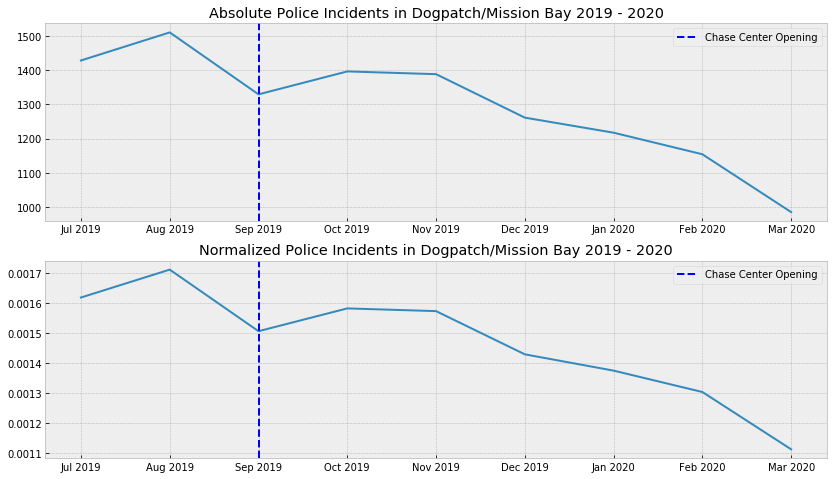

In [131]:
date_range = pd.date_range(start='2019-07-01', end='2020-03-31')
poljul19 = dataset[dataset['Incident Date'].isin(date_range)].sort_values(['Incident Date'])
calls = poljul19['Incident Category'].unique()
labels = poljul19.groupby(['Incident Year','Month']).count()['Incident Date']
min_year = poljul19['Incident Year'].min()
max_year = poljul19['Incident Year'].max()
plot_title = 'Police Incidents in Dogpatch/Mission Bay'

fig, ax = plt.subplots(2,1,figsize=(14,8))
ax[0].plot(poljul19['Month-Year'].unique(),poljul19.groupby(['Incident Year','Month']).count()['Incident Date'])
ax[0].axvline('Sep 2019', ls='--',color='blue', label='Chase Center Opening')
ax[0].set_title(f'Absolute {plot_title} {min_year} - {max_year}')
ax[0].set_xticks(poljul19['Month-Year'].unique())
ax[0].legend(loc='best')
ax[1].plot(poljul19['Month-Year'].unique(),poljul19.groupby(['Incident Year','Month']).sum()['Norm'])
ax[1].axvline('Sep 2019', ls='--',color='blue', label='Chase Center Opening')
ax[1].set_title(f'Normalized {plot_title} {min_year} - {max_year}')
ax[1].set_xticks(poljul19['Month-Year'].unique())
ax[1].legend(loc='best')
plt.savefig('Graphs/policeincidentmbdp2019-2020.png',dpi=300)

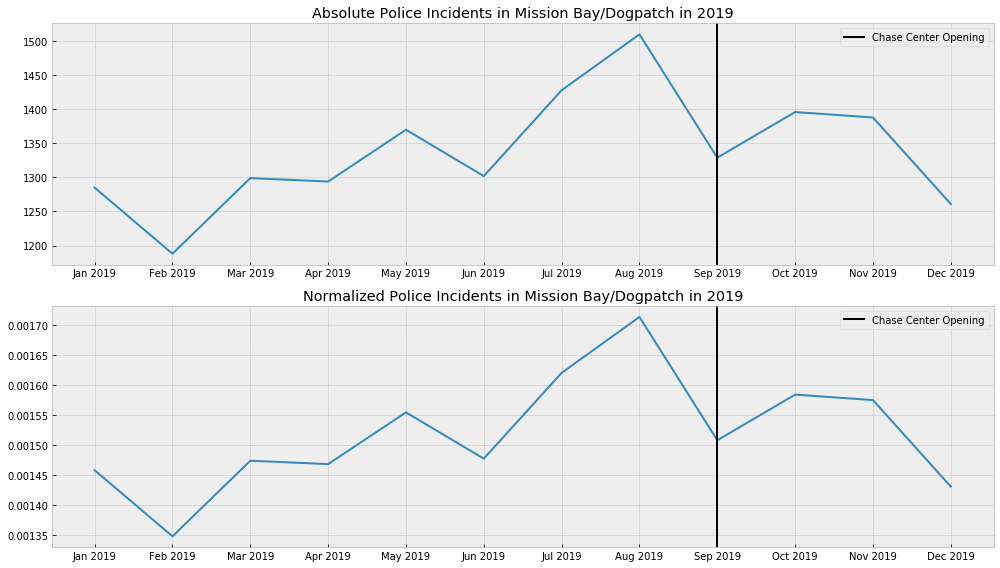

In [132]:
#Police Service Calls in a given year
year = 2019
pol2019 = dataset[dataset['Incident Year']==year].sort_values('Incident Date')
monthly = pol2019.groupby('Month')
months = pol2019['Month-Year'].unique()
plot_title = 'Police Incidents in Mission Bay/Dogpatch'

fig, ax = plt.subplots(2,1,figsize=(14,8))
ax[0].plot(months, monthly.count()['Norm'])
ax[0].axvline('Sep 2019', color='black', label='Chase Center Opening')
ax[0].set_xticks(months)
ax[0].set_title(f'Absolute {plot_title} in {year}')
ax[0].legend(loc='upper right')
ax[1].plot(months, monthly.sum()['Norm'])
ax[1].axvline('Sep 2019', color='black', label='Chase Center Opening')
ax[1].set_xticks(months)
ax[1].set_title(f'Normalized {plot_title} in {year}')
ax[1].legend(loc='upper right')
# plt.savefig('Graphs/2019_Crime_DPMS.png')
plt.tight_layout()
plt.show()

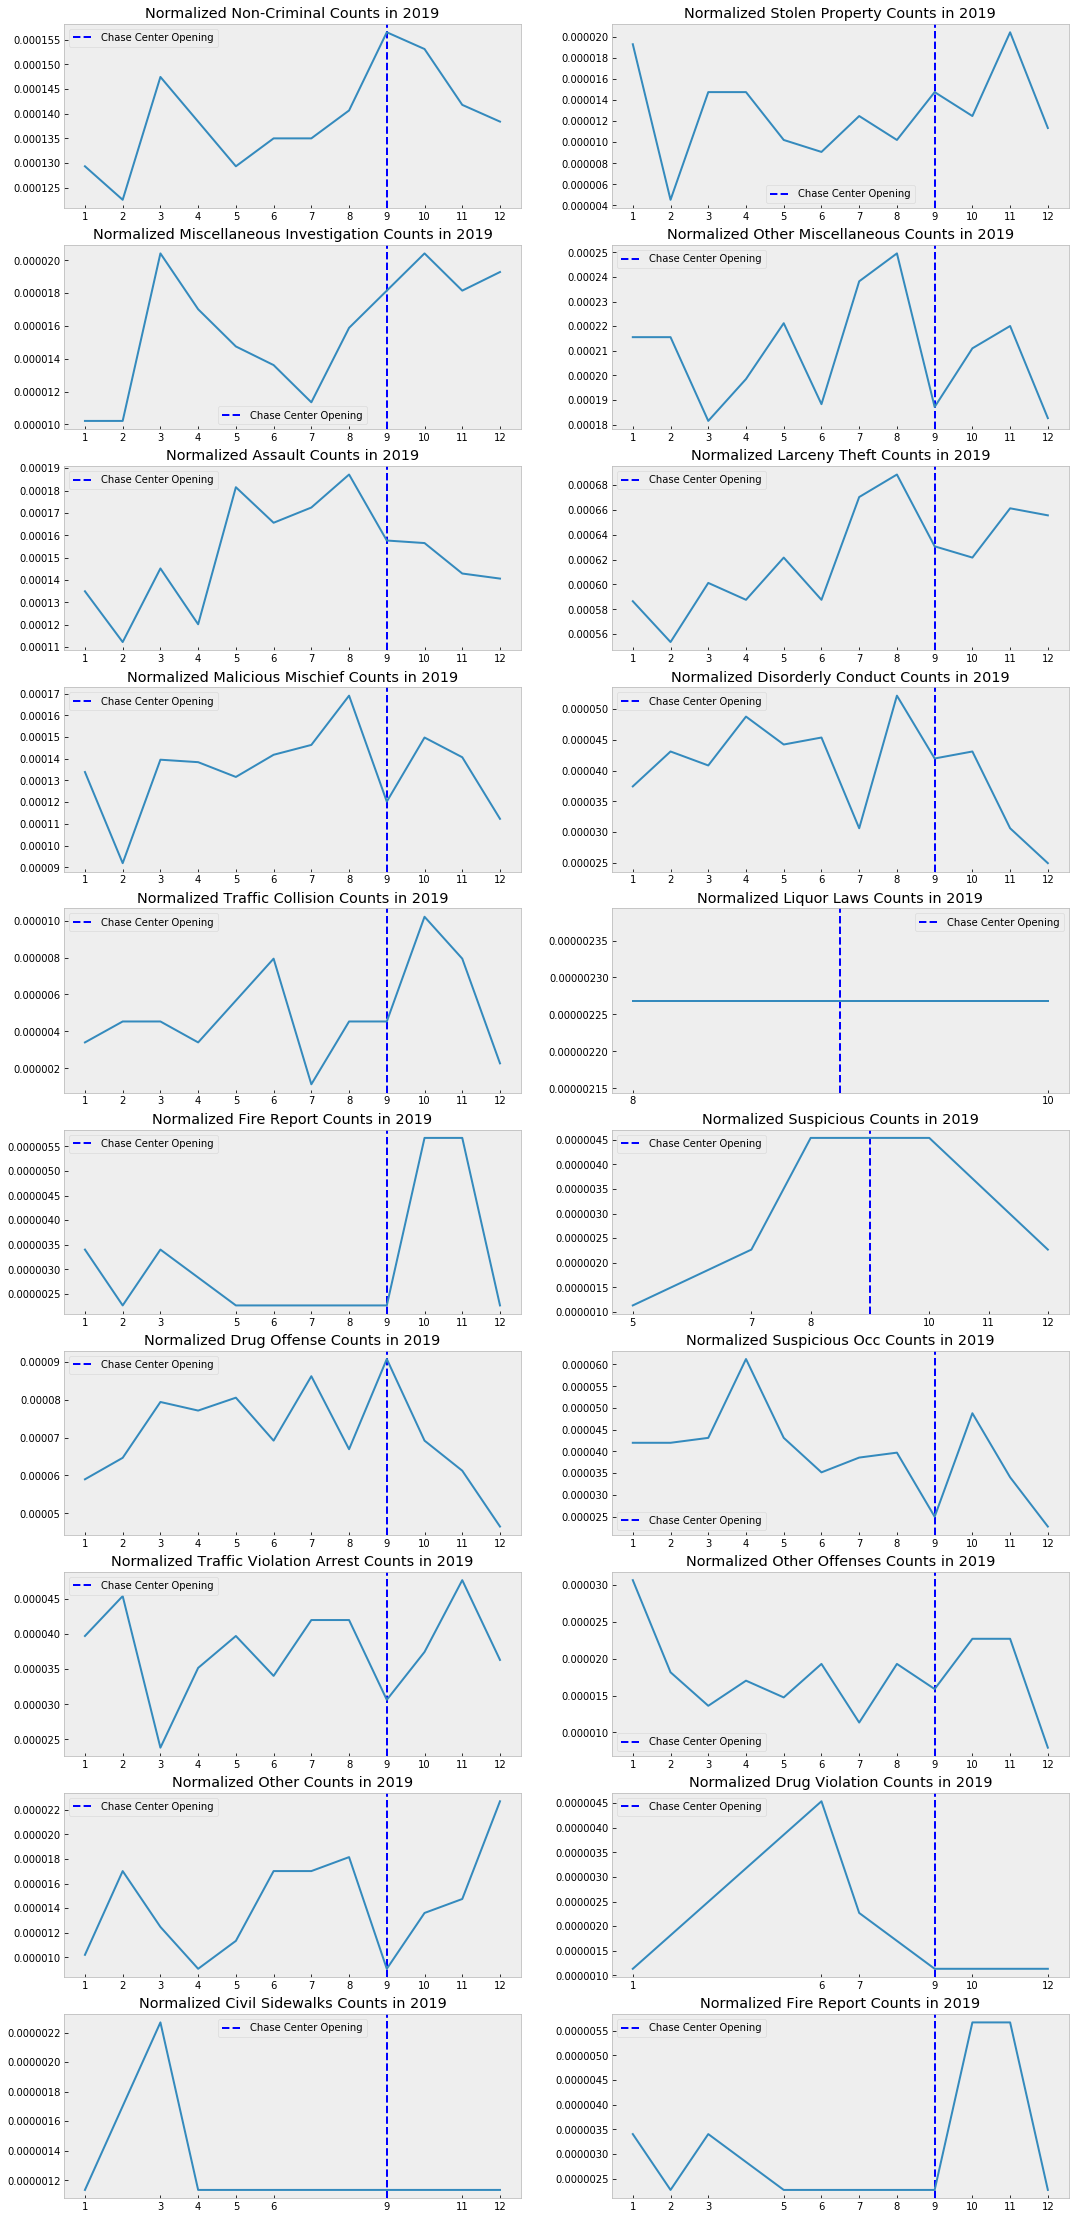

In [133]:
Normalized = 'yes'

fig, axes = plt.subplots(10,2, figsize=(18,40))
for ix, ax in enumerate(axes.flatten()):
    graph = pol2019[pol2019['Incident Category']==cats_of_interest[ix]].sort_values('Incident Date')
    ax.axvline(9, ls='--',color='blue', label='Chase Center Opening')
    ax.set_xticks(graph['Month'].unique())
    ax.legend(loc='best')
    ax.grid(None)
    if Normalized.lower() == 'yes':
        ax.plot(graph['Month'].unique(),graph.groupby('Month').sum()['Norm'])
        ax.set_title(f'Normalized {cats_of_interest[ix]} Counts in 2019')
    else:
        ax.plot(graph['Month'].unique(),graph.groupby('Month').count()['Norm'])
        ax.set_title(f'Absolute {cats_of_interest[ix]} Counts in 2019')

#     plt.savefig('Graphs/Absolute_Crime_DPMS.png')


/Users/sherryduong/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



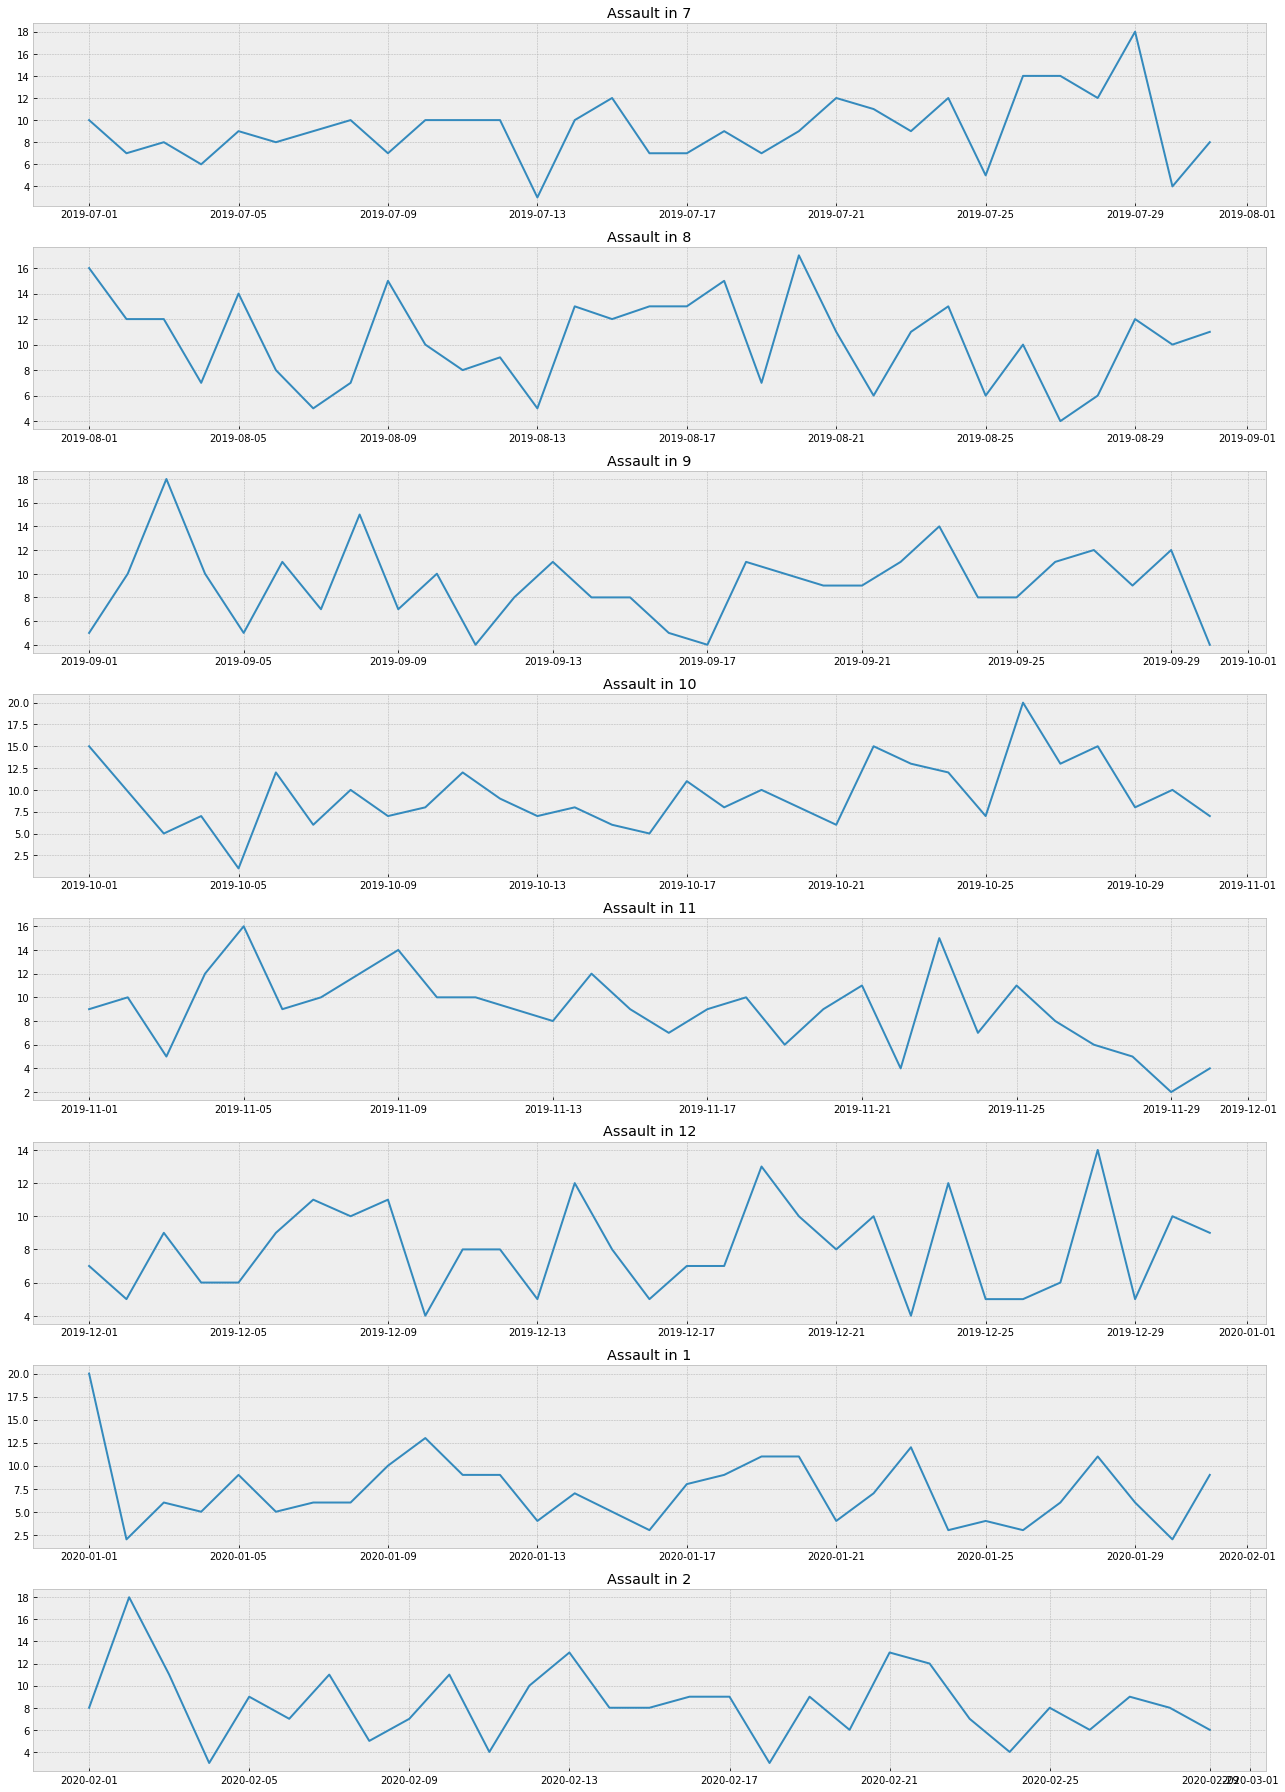

In [47]:
#Next step: Subplots per month for key indicators of interest: Medical Incidents, Alarms, Traffic Collisons
date_range = pd.date_range(start='2019-07-01', end='2020-04-01')
poljul19 = dataset[dataset['Incident Date'].isin(date_range)]
months = [7,8,9,10,11,12,1,2]
calls = ['Stolen Property','Miscellaneous Investigation','Other Miscellaneous','Assault', 'Larceny Theft', 
        'Disorderly Conduct','Traffic Collision','Fire Report', 'Suspicious', 'Drug Offense',
        'Suspicious Occ','Traffic Violation Arrest', 'Other Offenses', 'Other','Drug Violation']
event = calls[3]

fig, axes = plt.subplots(8,1, figsize=(18,25))
for ix, ax in enumerate(axes.flatten()):
    graph = poljul19[(poljul19['Month']==months[ix]) & (poljul19['Incident Category']==event)].sort_values('Incident Date')
    ax.plot(graph['Incident Date'].unique(),graph.groupby('Incident Date').count()['Norm'])
    ax.set_title(f'{event} in {months[ix]}')
fig.tight_layout()

## Takeaways
Because police incidents are downtrending in general, it makes more sense to only compare dates before and after the Chase Stadium opened.

## Hypothesis Testing:

**Null Hypothesis:** Average police incidents on game days will be the same as non-game days

**Alternative Hypothesis:** Average police incidents on game days will be higher than non-game days

In [164]:
#Import chase event dates
chase_events=pd.read_csv('Chase_Stadium_Events')
chase_events = chase_events.rename(columns = {'date':'Incident Date'})
chase_events['Incident Date'] = pd.to_datetime(chase_events['Incident Date'])
event_dates = chase_events['Incident Date'].unique()
chase_events = chase_events[['Incident Date','fields.type']]
chase_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 2 columns):
Incident Date    77 non-null datetime64[ns]
fields.type      77 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 1.3+ KB


In [165]:
#Only looking at categories in "Calls of interest"
date_range = pd.date_range(start='2019-09-06', end='2020-03-31')
pol2020 = dataset[dataset['Incident Date'].isin(date_range)]

events2020 = pol2020[pol2020['Incident Date'].isin(event_dates)]
eventdays = len(events2020['Incident Date'].unique())
events2020 = pd.merge(chase_events, events2020, on='Incident Date', how='left')
mean_events = events2020['Norm'].count()/len(events2020['Incident Date'].unique())
events_group = events2020.groupby('Incident Date').count()['Norm']
sd_events = np.std(events_group)

notevents2020 = pol2020[~pol2020['Incident Date'].isin(event_dates)]
noteventdays = len(notevents2020['Incident Date'].unique())
mean_not_events = notevents2020['Norm'].count()/len(notevents2020['Incident Date'].unique())
notevents_group = notevents2020.groupby('Incident Date').count()['Norm']
sd_notevents = np.std(notevents_group)

print(f'#Event Dates: {eventdays}, Mean: {mean_events}, SD: {sd_events}')
print(f'#Non-Event Dates: {noteventdays}, Mean: {mean_not_events}, SD: {sd_notevents}')

#Event Dates: 75, Mean: 44.49333333333333, SD: 12.297829980212857
#Non-Event Dates: 133, Mean: 39.69924812030075, SD: 10.96267417187005


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

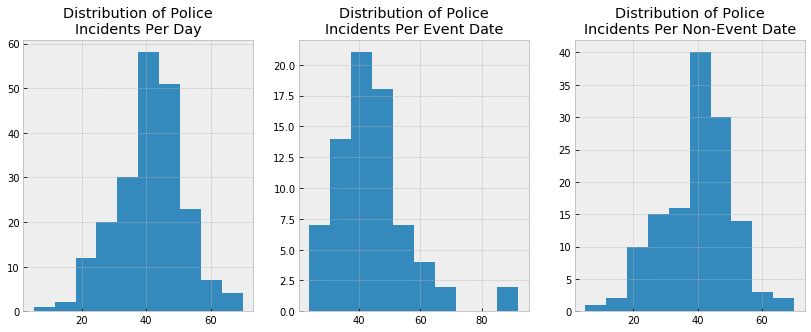

In [166]:
pol2020.head()
grouped = pol2020.groupby('Incident Date').count()['Norm']
fig, ax = plt.subplots(1,3, figsize=(14,5))
ax[0].hist(grouped,bins=10)
ax[0].set_title('Distribution of Police\nIncidents Per Day')
ax[1].hist(events_group,bins=10)
ax[1].set_title('Distribution of Police\nIncidents Per Event Date')
ax[2].hist(notevents_group,bins=10)
ax[2].set_title('Distribution of Police\nIncidents Per Non-Event Date')
plt.tight_layout
# plt.savefig('graphs/policeincidentdistribution.png', dpi=300)

**From the Distribution, it appears there are some outliers in the data**

In [167]:
stats.mannwhitneyu(events_group, notevents_group, alternative="greater")
#Based on the MannwhitneyTest Result, events at the Chase Center do have higher crime days

MannwhitneyuResult(statistic=5914.0, pvalue=0.013105124746150994)

Text(0.5, 1.0, 'Distribution of Police Incidents on Non-Event & Event Dates')

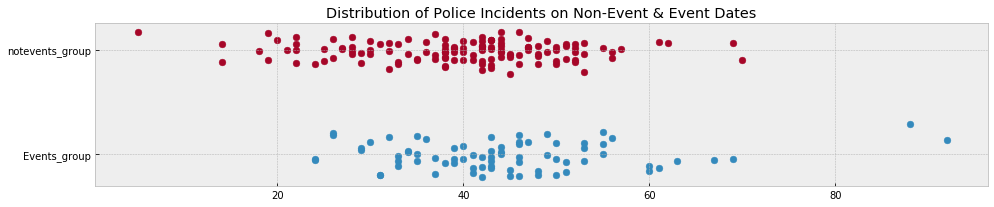

In [168]:
fig, ax = plt.subplots(1, figsize=(16, 3))

ax.scatter(events_group, np.repeat(0, len(events_group)) + np.random.normal(0, 0.1, len(events_group)), s=45)
ax.scatter(notevents_group, np.repeat(1, len(notevents_group)) + np.random.normal(0, 0.1, len(notevents_group)), s=45)
ax.set_yticks([0, 1])
ax.set_yticklabels(["Events_group", "notevents_group"])
ax.set_title('Distribution of Police Incidents on Non-Event & Event Dates')
# plt.savefig('Graphs/EventsVsNonScatter_Police.png',dpi=300)

Text(0.5, 1.0, '')

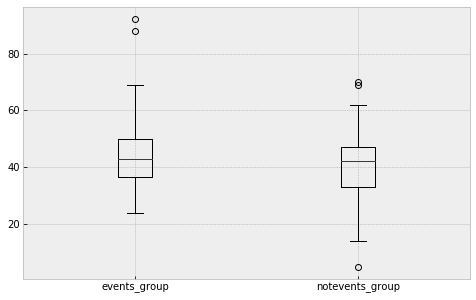

In [169]:
fig, ax = plt.subplots(1, figsize=(8, 5))
ax.boxplot([events_group, notevents_group])
ax.set_xticks([1,2])
ax.set_xticklabels(["events_group", "notevents_group"])
ax.set_title('')
# plt.savefig('Graphs/EventsVsNonBox_Police.png',dpi=300)

## Need to remove outliers in Events 

In [170]:
#Removing the outliers on 12/20 & 1/11
new_events2020 = events2020[~events2020['Incident Date'].isin(['2019-12-21', '2020-01-11'])]
new_events_group = new_events2020.groupby(['Incident Date']).count()['Norm']
mean_events_new = new_events2020['Norm'].count()/len(new_events2020['Incident Date'].unique())
sd_events_new = np.std(new_events2020.groupby('Incident Date').count()['Norm'])
print(f'Event Dates at Chase Stadium have on average {mean_events_new} Police Calls per day, {sd_events_new} SD')

Event Dates at Chase Stadium have on average 43.24657534246575 Police Calls per day, 9.847857456873493 SD


## Methodology
<br> Because the two sample sizes and SD are very different among the two samples, I will use the Non-Parametric MannWhitney U Test, and Welch's T-Test for hypothesis Testing

In [171]:
#Redo the mannwhitneyU without outliers
stats.mannwhitneyu(new_events_group, notevents_group, alternative="greater")

MannwhitneyuResult(statistic=5648.0, pvalue=0.026249186858916747)

In [172]:
T_test_Pval_two_tail = stats.ttest_ind(new_events_group, notevents_group, equal_var = False)
T_test_Pval = T_test_Pval_two_tail[1]/2
T_test_Pval

0.00970798092544774

In [173]:
def welch_test_statistic(sample_1, sample_2):
    numerator = np.mean(sample_1) - np.mean(sample_2)
    denominator_sq = (np.var(sample_1) / len(sample_1)) + (np.var(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)
test_statistic = welch_test_statistic(new_events_group, notevents_group)
print("Welch Test Statistic: {:2.2f}".format(test_statistic))

Welch Test Statistic: 2.37


In [174]:
def welch_satterhwaithe_df(sample_1, sample_2):
    ss1 = len(sample_1)
    ss2 = len(sample_2)
    df = (
        ((np.var(sample_1)/ss1 + np.var(sample_2)/ss2)**(2.0)) / 
        ((np.var(sample_1)/ss1)**(2.0)/(ss1 - 1) + (np.var(sample_2)/ss2)**(2.0)/(ss2 - 1))
    )
    return df
df = welch_satterhwaithe_df(new_events_group, notevents_group)
df

162.2992544735174

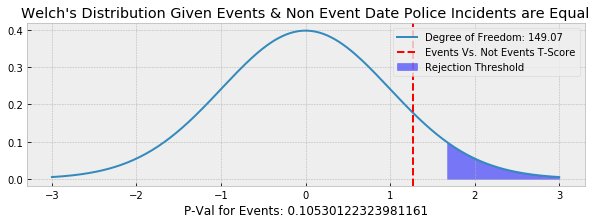

In [184]:
x = np.linspace(-3, 3, num=250)

fig, ax = plt.subplots(1, figsize=(10, 3))
notevents_tdist = stats.t(df)
p_val = (1-notevents_tdist.cdf(test_statistic-.01))
critical_val = notevents_tdist.ppf(0.95)
ax.plot(x, notevents_tdist.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(df))
ax.fill_between(x, notevents_tdist.pdf(x), where=(x >= critical_val), color="blue", alpha=0.5, label='Rejection Threshold')
ax.axvline(test_statistic, color='red', ls='--', label='Events Vs. Not Events T-Score')
ax.set_xlabel(f'P-Val for Events: {p_val}')
ax.legend(loc='upper right')
ax.set_title("Welch's Distribution Given Events & Non Event Date Police Incidents are Equal")
# plt.savefig('Graphs/EventsVsNonHypotheisTest_Police.png')

### Based on these results, there appears to be a significant difference in Police Incidents between Event Dates and Non Event Dates.

## Events are typically on weekends > Is this driving up the mean?

In [148]:
new_events2020['Day of Week'] = new_events2020['Incident Date'].transform(lambda x: x.dayofweek)
notevents2020['Day of Week'] = notevents2020['Incident Date'].transform(lambda x: x.dayofweek)
new_events2020['Norm'] = 1/len(new_events2020)
notevents2020['Norm'] = 1/len(notevents2020)

In [149]:
new_events2020.groupby('Day of Week').sum()['Norm']

Day of Week
0    0.140006
1    0.107380
2    0.133671
3    0.155211
4    0.144124
5    0.232499
6    0.087108
Name: Norm, dtype: float64

In [150]:
notevents2020.groupby('Day of Week').sum()['Norm']

Day of Week
0    0.142803
1    0.146970
2    0.158333
3    0.121591
4    0.172917
5    0.086932
6    0.170455
Name: Norm, dtype: float64

**Events have a bias towards Saturdays/Thursdays which would be interesting to look into**

## What About Accounting For Shelter In Place 3/19/2020+?

In [177]:
#Only looking at categories in "Calls of interest"
date_range = pd.date_range(start='2019-09-06', end='2020-03-19')
pol2020 = dataset[dataset['Incident Date'].isin(date_range)]
events2020 = pol2020[pol2020['Incident Date'].isin(event_dates)]
eventdays = len(events2020['Incident Date'].unique())
notevents2020 = pol2020[~pol2020['Incident Date'].isin(event_dates)]
noteventdays = len(notevents2020['Incident Date'].unique())
events2020 = pd.merge(chase_events, events2020, on='Incident Date', how='left')
print(f'Number of Event Dates: {eventdays} Number of Non-Event Dates: {noteventdays}')
print(f'Incidents on Event Dates: {len(events2020)}, Incidents not on Event Dates: {len(notevents2020)}')

Number of Event Dates: 75 Number of Non-Event Dates: 121
Incidents on Event Dates: 3337, Incidents not on Event Dates: 5011


In [178]:
events_group = events2020.groupby(['Incident Date','fields.type']).count()['Norm']
mean_events = events2020['Norm'].count()/len(events2020['Incident Date'].unique())
notevents_group = notevents2020.groupby('Incident Date').count()['Norm']
mean_not_events = notevents2020['Norm'].count()/len(notevents2020['Incident Date'].unique())
new_events2020 = events2020[~events2020['Incident Date'].isin(['2019-12-21', '2020-01-11'])]
new_events_group = new_events2020.groupby(['Incident Date']).count()['Norm']
mean_events_new = new_events2020['Norm'].count()/len(new_events2020['Incident Date'].unique())
sd_events_new = np.std(new_events2020.groupby('Incident Date').count()['Norm'])
print(f'Event Dates at Chase Stadium have on average {mean_events_new} Police Calls per day, {sd_events_new} SD')

Event Dates at Chase Stadium have on average 43.24657534246575 Police Calls per day, 9.847857456873493 SD


In [179]:
stats.mannwhitneyu(new_events_group, notevents_group, alternative="greater")

MannwhitneyuResult(statistic=4814.0, pvalue=0.1471616387558109)

In [180]:
T_test_Pval_two_tail = stats.ttest_ind(new_events_group, notevents_group, equal_var = False)
T_test_Pval = T_test_Pval_two_tail[1]/2
T_test_Pval

0.10484373806923149

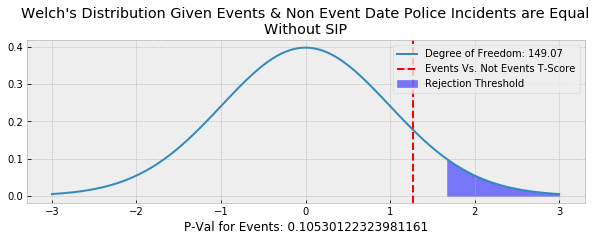

In [185]:
def welch_test_statistic(sample_1, sample_2):
    numerator = np.mean(sample_1) - np.mean(sample_2)
    denominator_sq = (np.var(sample_1) / len(sample_1)) + (np.var(sample_2) / len(sample_2))
    return numerator / np.sqrt(denominator_sq)
test_statistic = welch_test_statistic(new_events_group, notevents_group)
def welch_satterhwaithe_df(sample_1, sample_2):
    ss1 = len(sample_1)
    ss2 = len(sample_2)
    df = (
        ((np.var(sample_1)/ss1 + np.var(sample_2)/ss2)**(2.0)) / 
        ((np.var(sample_1)/ss1)**(2.0)/(ss1 - 1) + (np.var(sample_2)/ss2)**(2.0)/(ss2 - 1))
    )
    return df
df = welch_satterhwaithe_df(new_events_group, notevents_group)
x = np.linspace(-3, 3, num=250)

fig, ax = plt.subplots(1, figsize=(10, 3))
notevents_tdist = stats.t(df)
p_val = (1-notevents_tdist.cdf(test_statistic-.01))
critical_val = notevents_tdist.ppf(0.95)
ax.plot(x, notevents_tdist.pdf(x), linewidth=2, label="Degree of Freedom: {:2.2f}".format(df))
ax.fill_between(x, notevents_tdist.pdf(x), where=(x >= critical_val), color="blue", alpha=0.5, label='Rejection Threshold')
ax.axvline(test_statistic, color='red', ls='--', label='Events Vs. Not Events T-Score')
ax.set_xlabel(f'P-Val for Events: {p_val}')
ax.legend(loc='upper right')
ax.set_title("Welch's Distribution Given Events & Non Event Date Police Incidents are Equal\nWithout SIP")
# plt.savefig('Graphs/EventsVsNonHypotheisTest_PoliceWOSIP.png')

## Shelter In Place has helped to bring the crime rate down for Non-Event Dates, making the difference between Event & Non-Event Dates seem bigger than it is.
<br>**Based on these results, we can conclude that Event Dates & Non-Event Dates have the same rate of police incidents, however Shelter In Place appears to have a difference in rate from pre-Shelter In Place.**

## What about Basketball versus Concerts?

In [156]:
bball_dates = chase_events[chase_events['fields.type']=='gsw']['Incident Date'].unique()
concert_dates = chase_events[chase_events['fields.type']=='cce']['Incident Date'].unique()
bball_events = new_events2020[new_events2020['Incident Date'].isin(bball_dates)]
concert_events = new_events2020[new_events2020['Incident Date'].isin(concert_dates)]

In [157]:
bball_group = bball_events.groupby('Incident Date').count()['Norm']
concert_group = concert_events.groupby('Incident Date').count()['Norm']
bball_mean = np.mean(bball_group)
bball_sd = np.std(bball_group)
bball_se = bball_sd/(np.sqrt(len(bball_group)))
concert_mean = np.mean(concert_group)
concert_sd = np.std(concert_group)
concert_se = concert_sd/np.sqrt(len(concert_group))
print(f'Bball Mean: {bball_mean}, Concert Mean: {concert_mean}')
print(f'Bball sd: {bball_sd}, Concert sd: {concert_sd}')
print(f'Bball se: {bball_se}, Concert Mean: {concert_se}')

Bball Mean: 42.513513513513516, Concert Mean: 44.0
Bball sd: 11.303244264301556, Concert sd: 8.013876853447538
Bball se: 1.8582419103162642, Concert Mean: 1.3356461422412564


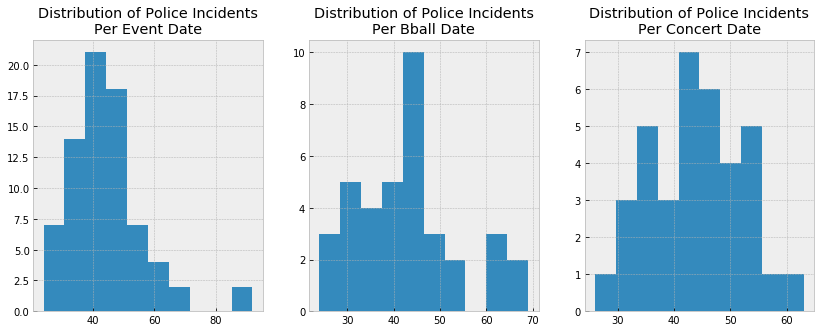

In [158]:
fig, ax = plt.subplots(1,3, figsize=(14,5))
ax[0].hist(events_group,bins=10)
ax[0].set_title('Distribution of Police Incidents\nPer Event Date')
ax[1].hist(bball_group,bins=10)
ax[1].set_title('Distribution of Police Incidents\nPer Bball Date')
ax[2].hist(concert_group,bins=10)
ax[2].set_title('Distribution of Police Incidents\nPer Concert Date')
plt.tight_layout
plt.savefig('graphs/policesbballconcertdist.png', dpi=300)

In [159]:
stats.mannwhitneyu(concert_group, bball_group, alternative="greater")

MannwhitneyuResult(statistic=753.5, pvalue=0.16832384083857832)

In [160]:
T_test_Pval_two_tail = stats.ttest_ind(concert_group, bball_group, equal_var = False)
T_test_Pval = T_test_Pval_two_tail[1]/2
print(f'The P-Val for Concert to Bball Events is: {T_test_Pval}')

The P-Val for Concert to Bball Events is: 0.2620054983727691


### There appears to be no difference between the impact of Basketball Events or Concerts.